In [1]:
from SymPT import *
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.linalg as la


In [2]:
#plt.style.use("classic")
cmap = plt.get_cmap('inferno')
plt.rc('text', usetex = True)
plt.rc('font', family = 'serif', weight = 'normal')
plt.rc('font', size = 18)
color_list = [cmap(i) for i in np.linspace(0, 1, 16)]
fntsize = 20
dir_images = "graphs/"

# Hamiltonian

In [3]:
def substitution_rules(I, J, omegas, lambdas):
    """Returns 2 dictionaries containing substitution rules for H"""
    omega_values = np.sort([np.random.uniform(-10, 10) for _ in range(I)])  
    substitution_dict = {omegas[i]: omega_values[i] for i in range(I)}
    substitution_omegas = {omegas[i]: omega_values[i] for i in range(I)}

    lambda_index = 0
    for i in range(I):
        for j in range(i+1, J):  # Iterate only over the upper triangular part
            bound = 0.1**(lambdas[lambda_index].order) * abs(omega_values[i] - omega_values[j])            
            lambda_value = bound             
            substitution_dict[lambdas[lambda_index]] = lambda_value 
            lambda_index += 1
            
    return substitution_dict, substitution_omegas


In [4]:
def create_Hamiltonian(I, J, mask):
    #lambdas = [RDSymbol(f"\\lambda_{i}", order = 1, real = True) for i in range(int((I**2 -I))//2)]
    omegas = [RDSymbol(f"\\omega_{i}", order = 0, real = True) for i in range(I)]

    H = sp.zeros(I, J)
    lambdas = []
    for i in range(I):
        H[i, i] = omegas[i]  # Diagonal elements
        for j in range(i + 1, J):
            lambdas.append(RDSymbol(f"\\lambda_{i}_{j}", order = 1 + mask[i, j], real = True))
            H[i, j] = lambdas[-1]
            H[j, i] = lambdas[-1]
            
    return H, omegas, lambdas

# Exact Block Diagonalization

In [5]:
def exact_block_diagonalization(Hh, mask):
    # Unitary transformation
    _, X = la.eigh(Hh)
    
    X_inv = np.linalg.inv(X)
    
    B_mask = lambda x: np.logical_not(mask) * 1 * x

    T = X @ B_mask(X_inv) @ la.fractional_matrix_power(B_mask(X) @ B_mask(X_inv), -1/2)

    return la.inv(T) @ Hh @ T


# Least Action Method

In [184]:
def get_order_elements(E0, E1, V):
    E0_energy = np.linalg.norm(E0) if len(E0.shape) == 2 else E0
    E1_energy = np.linalg.norm(E1) if len(E1.shape) == 2 else E1
    return np.linalg.norm(V) / (E0_energy - E1_energy)

In [ ]:
# Creating random block structure 
max_size = 5

b_dims = np.random.randint(5, size=5)
while  len(b_dims[b_dims !=0]) < 2 or np.sum(b_dims) == 0 or np.sum(b_dims) > max_size:
    b_dims = np.random.randint(5, size=5)
structure = get_structure(b_dims)
mask = Block(structure)

# Creating random Hamiltonian
I, J = structure.shape
print(I, J)
H, omegas, lambdas = create_Hamiltonian(I, J, structure)
values, omegas_dict = substitution_rules(I,J, omegas, lambdas)

Hh = np.array(H.subs(values), dtype=float)


H_blocks = []
V_blocks = []
prev_dim = 0
b_dims = b_dims[b_dims != 0]
for d in b_dims:
    H_blocks.append(Hh[prev_dim: prev_dim + d, prev_dim:prev_dim + d])
    prev_dim += d

prev_d1 = 0
prev_d1_d2 = 0
for i, d1 in enumerate(b_dims):
    prev_d1_d2 = prev_d1 + d1
    for d2 in b_dims[i + 1:]:
        print(f'rows: {prev_d1}:{prev_d1 + d1-1}, cols: {prev_d1_d2}:{prev_d1_d2 + d2-1}')
        V_blocks.append(Hh[prev_d1:prev_d1 + d1, prev_d1_d2:prev_d1_d2 + d2])
        prev_d1_d2 += d2
    prev_d1 += d1

for i, block in enumerate(H_blocks):
    print(f'Block {i}:')
    print(block)

5 5
rows: 0:1, cols: 2:3
rows: 0:1, cols: 4:4
rows: 2:3, cols: 4:4


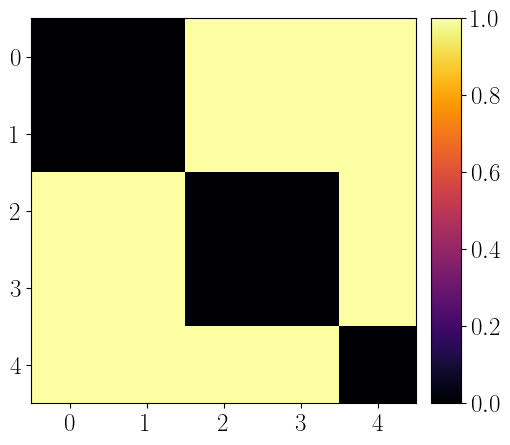

In [56]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5), dpi = 100)
im = ax.imshow(np.array(structure, dtype=float), cmap='inferno') # Initial Hamiltonian
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax)
#plt.savefig('LA_mask.pdf',  bbox_inches='tight')

In [8]:
# Initializing effective frame
Eff_Frame = EffectiveFrame(H, symbol_values = values, verbose = True)

Creating the EffectiveFrame object with matrix form.
The EffectiveFrame object has been initialized successfully.


In [9]:
# Calculate the effective model using mask
max_order = 8 # perturbation order
Eff_Frame.solve(max_order = max_order, method = "LA", mask=mask)

# Obtaining the result in the matrix form
LA_result = Eff_Frame.get_H(return_form = "matrix")

Substituting the symbol values in the Hamiltonian and perturbative interactions.
Rotating for each order: 100%|██████████| 8/8 [00:27<00:00,  3.41s/it]
The Hamiltonian has been solved successfully. Please use the get_H method to get the result in the desired form.
Converting to matrix form: 100%|██████████| 9/9 [00:00<00:00, 12071.87it/s]


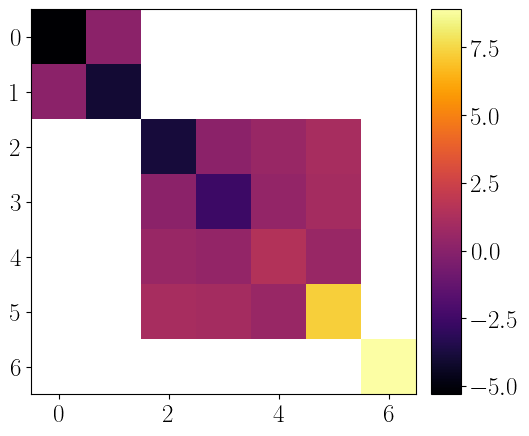

In [10]:
# Plotting
np_LA = np.array(LA_result,dtype=float)
np_LA[np.abs(np_LA) < 1e-12] = None # setting zero values to None
fig, ax = plt.subplots(figsize=(15, 5), dpi = 100)
im = ax.imshow(np.array(np_LA, dtype=float), cmap='inferno') # Initial Hamiltonian
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax)
#plt.savefig('LA_masked_hamiltonian.pdf',  bbox_inches='tight')

In [ ]:
# Obtainining initial Hamiltonian (with values) and exact bd transformation
exact_result = exact_block_diagonalization(Hh, structure)

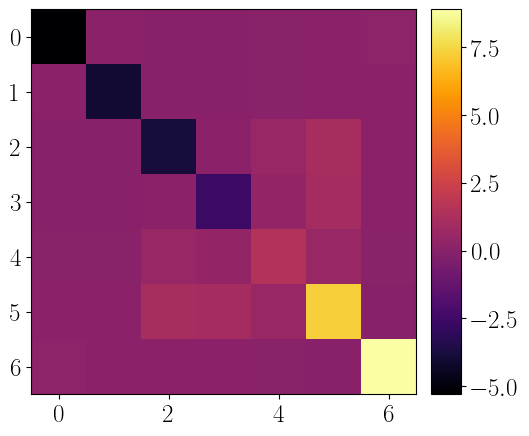

In [12]:
# Plotting
fig, ax = plt.subplots(figsize=(15, 5), dpi = 100)
im = ax.imshow(np.array(Hh, dtype=float), cmap='inferno') # Initial Hamiltonian# numpy seed    
np.random.seed(0)
cax0 = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
fig.colorbar(im, cax=cax0)
#plt.savefig('LA_non_masked_hamiltonian.pdf',  bbox_inches='tight')

# Comparison with exact result

In [19]:
def fidelity(A, B):
    return np.abs(A - B).max()
    return np.linalg.norm(A - B) / np.linalg.norm(A)

In [20]:
LA_corrections = Eff_Frame.corrections # extracting order corrections from effective frame
error_order = [] # will store solutions to each order
LA_res = np.zeros_like(exact_result) # initializing result
LA_res_order = []
for order in range(max_order + 1): 
    LA_res += np.array(LA_corrections.get(order, sp.zeros(*exact_result.shape)).evalf(), dtype=float) # correcting result with current order
    LA_res_order.append(LA_res.copy())
    error_order.append(fidelity(exact_result, LA_res)) # append fidelity of current order
    print(f"Order {order}: {error_order[-1]}")

Order 0: 1.0737139111372604
Order 1: 0.03701342476194003
Order 2: 0.03701342476194003
Order 3: 0.03701342476194003
Order 4: 0.03757123801820783
Order 5: 0.030596393788113296
Order 6: 0.030681193454753064
Order 7: 0.024680277478682733
Order 8: 0.025847579398448284


In [43]:
sp.Matrix(Hh*structure)

Matrix([
[               0.0,                 0.0,  0.0147407779617128, 0.0267094428173365, 0.0682314740924723,  0.125813511551633,  0.142083867929849],
[               0.0,                 0.0, 0.00177453724832149, 0.0137432021039452,  0.055265233379081,  0.112847270838241,  0.129117627216458],
[0.0147407779617128, 0.00177453724832149,                 0.0,                0.0,                0.0,                0.0,  0.127343089968136],
[0.0267094428173365,  0.0137432021039452,                 0.0,                0.0,                0.0,                0.0,  0.115374425112512],
[0.0682314740924723,   0.055265233379081,                 0.0,                0.0,                0.0,                0.0, 0.0738523938373767],
[ 0.125813511551633,   0.112847270838241,                 0.0,                0.0,                0.0,                0.0, 0.0162703563782162],
[ 0.142083867929849,   0.129117627216458,   0.127343089968136,  0.115374425112512, 0.0738523938373767, 0.0162703563782162,     

In [46]:
HB1 = Hh[0:2, 0:2]
display(sp.Matrix(HB1))
HB2 = Hh[2:6, 2:6]
display(sp.Matrix(HB2))
HB3 = Hh[6, 6]
display(sp.Matrix([HB3]))

V12 = Hh[0:2, 2:6]
display(sp.Matrix(V12))
V13 = Hh[0:2, 6]
display(sp.Matrix(V13))
V23 = Hh[2:6, 6]
display(sp.Matrix(V23))

Matrix([
[-5.30020088445608, 0.129662407133913],
[0.129662407133913, -4.00357681311695]])

Matrix([
[ -3.8261230882848, 0.119686648556237, 0.534906961307595,   1.1107273358992],
[0.119686648556237, -2.62925660272243, 0.415220312751358, 0.991040687342962],
[0.534906961307595, 0.415220312751358,  1.52294652479115, 0.575820374591604],
[  1.1107273358992, 0.991040687342962, 0.575820374591604,  7.28115027070719]])

Matrix([[8.90818590852881]])

Matrix([
[ 0.0147407779617128, 0.0267094428173365, 0.0682314740924723, 0.125813511551633],
[0.00177453724832149, 0.0137432021039452,  0.055265233379081, 0.112847270838241]])

Matrix([
[0.142083867929849],
[0.129117627216458]])

Matrix([
[ 0.127343089968136],
[ 0.115374425112512],
[0.0738523938373767],
[0.0162703563782162]])

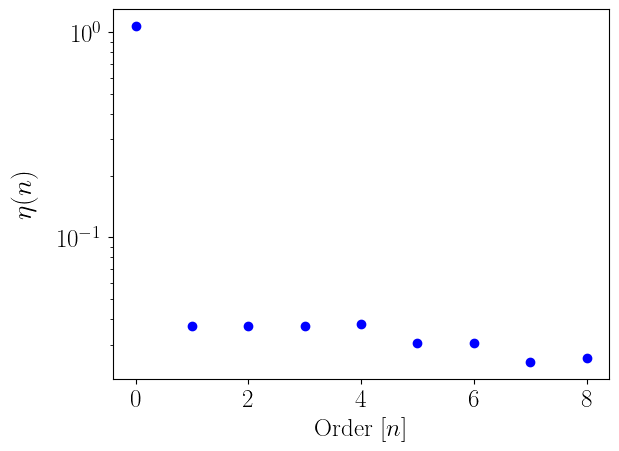

In [21]:
fig, ax = plt.subplots(1, 1)

ax.scatter(np.arange(0,max_order+1), error_order, color='blue')

ax.set_xlabel("Order $[n]$")
ax.set_ylabel(r"$\eta(n)$", fontsize=fntsize, labelpad=15)
ax.set_yscale('log')
#plt.savefig('LA_error_vs_order.pdf',  bbox_inches='tight')